In [1]:
import librosa
import librosa.display
from IPython.display import Audio
import time
import matplotlib.pyplot as plt
import numpy as np
from constants import *
import postprocessing
import preprocessing

def bpm_estimation(onsets_times, max_dev=2, show_plot=True):
    bpms = 60 / (onsets_times[1:] - onsets_times[:-1])
    median_bpm = np.median(bpms) # s/b
    selected_bpms = bpms[np.abs(bpms - median_bpm) < max_dev]
    if len(selected_bpms) > 0:
        bpm = np.mean(selected_bpms)
    else:
        print("mean didn't work")
        bpm = median_bpm
    if show_plot == True:
        print(bpm)
        plt.plot(bpms)
        plt.plot(np.arange(len(bpms)), np.zeros(len(bpms)) + bpm);
    return bpm

In [2]:
song_name = 'bye-bye-blackbird-03'
song_path = 'data/JAZZ/audio/keith-jarrett/bye-bye-blackbird-03.m4a'

In [3]:
total_duration = librosa.get_duration(filename=song_path)
print(f'Total duration: {total_duration:.2f} seconds')

Total duration: 397.31 seconds


In [4]:
offset = 0
duration = total_duration
wav = librosa.load(song_path, sr, offset=offset, duration=duration)[0]

In [5]:
calibration_path = './data/tmp/calibration.wav'

n = 12                       # Number of beats played before the song starts to calibrate.
bpm = 120                    # BPM of those beats.
period = int(sr * 60 / bpm)  # samples per beat
stretch = 2                  # factor by which to stretch the wav
click_volume = 4

calibration_beats_times = np.arange(1, n + 1, dtype=np.float) * period / sr
clicks = librosa.clicks(calibration_beats_times, sr=sr, length=(n+1)*period)
start_time = len(clicks) / sr
clicks *= click_volume / 10
wav_stretched = librosa.effects.time_stretch(wav, 1 / stretch)
calibration_wav = np.concatenate((clicks, wav_stretched))
librosa.output.write_wav(calibration_path, calibration_wav, sr)

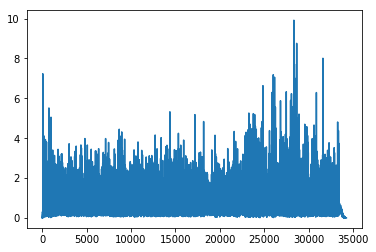

In [6]:
onsets_env = preprocessing.onset_strength(wav=wav)
plt.plot(onsets_env);

In [7]:
onsets_env = onsets_env / 5

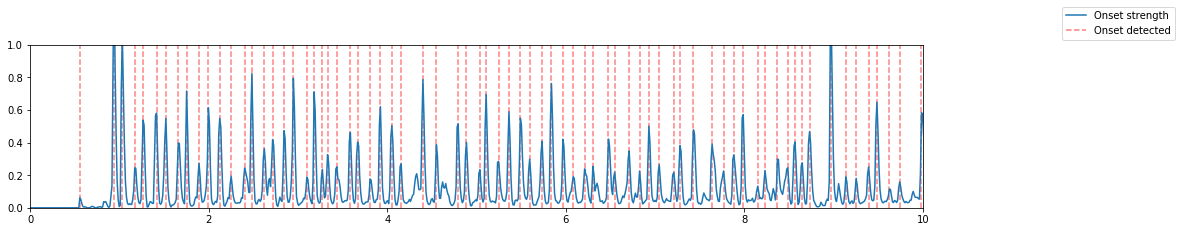

In [8]:
onsets = preprocessing.peak_detect(onsets_env)
times        = librosa.frames_to_time(np.arange(len(onsets_env)), sr, hl)
onsets_times = librosa.frames_to_time(onsets, sr, hl)
plt.figure(figsize=(16, 3))
plt.plot(times, onsets_env, label='Onset strength')
plt.vlines(onsets_times, 0, 1, alpha=0.5, color='r', linestyle='--', label='Onset detected')
plt.legend(frameon=True, framealpha=0.75, bbox_to_anchor=(1.15, 1))
plt.ylim(0, 1)
plt.xlim(0, 10);

In [ ]:
beats_times_recorded = np.loadtxt('./data/tmp/beats.txt')

In [ ]:
calibration_onsets_env = preprocessing.onset_strength(wav=calibration_wav)
calibration_onsets_env /= 5
calibration_onsets = preprocessing.peak_detect(calibration_onsets_env)
calibration_onsets_times = librosa.frames_to_time(calibration_onsets, sr, hl)
calibration_offset = (beats_times_recorded[:n - 4] - calibration_onsets_times[4:n]).mean()
calibration_beats_times = beats_times_recorded - calibration_offset

plt.figure(figsize=(16, 2))
plt.vlines(calibration_beats_times, 0.5, 1, color='b', linestyle='-', label='Beats recorded')
plt.vlines(calibration_onsets_times, 0, 0.5, color='r', linestyle='-', label='Onsets detected')
plt.legend(frameon=True, framealpha=0.75, bbox_to_anchor=(1.15, 1))
plt.plot(librosa.frames_to_time(np.arange(len(calibration_onsets_env)), sr, hl), calibration_onsets_env)
plt.ylim(0, 1)
d = 40
plt.xlim(d, d + 5)
#plt.xlim(0, int((n + 1) * period) + 1);

In [ ]:
beats_times = (calibration_beats_times[calibration_beats_times > start_time] - start_time + 0.03) / stretch

In [ ]:
plt.figure(figsize=(16, 3))
plt.vlines(beats_times, 1, 1.5, color='g', linestyle='-', label='Beats recorded')
plt.vlines(onsets_times, 0, 1, alpha=0.5, color='r', linestyle='--', label='Onset detected')
plt.plot(times, onsets_env, label='Onset strength')
plt.legend(frameon=True, framealpha=0.75, bbox_to_anchor=(1.15, 1))
plt.ylim(0, 1.5)
plt.xlim((d - 6.5) / 2, (d - 6.5 + 5) / 2);

In [ ]:
clicks = librosa.clicks(beats_times, sr=sr, length=len(wav))
slow = librosa.effects.time_stretch(wav + clicks / 6, 1/2)
librosa.output.write_wav('data/tmp/clicks.wav', slow, sr=sr)

The goal is now to go over each recored first beat and check if there is an onset close enough to it.

In [ ]:
selected_idxs = preprocessing.select_onsets(onsets_times, beats_times)
selected_onsets = onsets[selected_idxs]
selected_onsets_times = onsets_times[selected_idxs]

plt.figure(figsize=(16, 3))
plt.plot(times, librosa.util.normalize(onsets_env), label='Onset strength')
plt.vlines(onsets_times, 0, 1, alpha=0.1, color='k', linestyle='--', label='Onset detected')
plt.vlines(selected_onsets_times, 0, 1, alpha=0.5, color='r', linestyle='--', label='Onset selected')
plt.vlines(beats_times, 1, 1.3, alpha=0.5, color='b', linestyle='-', label='Beats recored')
plt.legend(frameon=True, framealpha=0.75, bbox_to_anchor=(1.15, 1))
plt.ylim(0, 1.2);
plt.xlim(35, 45);

In [ ]:
sample_length = 10
overlap = 2
N = int(duration / (sample_length - overlap))
N

In [ ]:
bts = []
for i in range(N):
    start_time = i * (sample_length - overlap)
    end_time   = start_time + sample_length
    b = beats_times[(start_time <= beats_times) & (beats_times < end_time)]
    bpm = bpm_estimation(b, show_plot=False)
    start = librosa.time_to_frames(start_time, sr, hl)
    end   = librosa.time_to_frames(end_time, sr, hl)
    so = selected_onsets[(start <= selected_onsets) & (selected_onsets < end)]
    cb = postprocessing.beat_tracker(so, so.max() + 10, bpm, 800)
    if i == 0:
        bts += list(cb[:-2])
    elif i == N - 1:
        bts += list(cb[cb > bts[-1]])
    else:
        bts += list(cb[cb > bts[-1]][:-2])
beats = librosa.frames_to_time(bts, sr, hl)[1:]

In [ ]:
bpms = 60 / (beats[1:] - beats[:-1])
a = 8
avs = [bpms[i: i + a].mean() for i in range(len(bpms) - a)]
plt.xlabel('Time')
plt.ylabel('BPM')
plt.plot(beats[a:-1], avs);

In [ ]:
selected_idx = preprocessing.select_onsets(onsets_times, beats)
selected_onsets_times = onsets_times[selected_idx]

In [ ]:
plt.figure(figsize=(15, 4))
plt.vlines(beats_times, 1.2, 1.4, color='g', linestyle='-', label='Beats recorded')
plt.vlines(beats, 1, 1.2, color='b', linestyle='-', label='Beats generated')
plt.vlines(onsets_times, 0, 1, alpha=0.1, color='k', linestyle='--', label='Onsets detected')
plt.vlines(selected_onsets_times, 0, 1, alpha=0.5, color='r', linestyles='--', label='Selected onsets')
plt.plot(times, librosa.util.normalize(onsets_env), label='Onset strength')
plt.legend(frameon=True, framealpha=0.75, bbox_to_anchor=(1.15, 1))
plt.ylim(0, 1.4);
t = 10
plt.xlim(t, t + 10);

In [ ]:
beat_track = librosa.clicks(beats - 0.02, sr=sr, length=len(wav)) / 4
btaw = wav + beat_track #librosa.effects.time_stretch(wav + beat_track, 1/2)
librosa.output.write_wav('./data/tmp/clicks.wav', btaw, sr)

Use the beat tracker to complete the selected beats.

In [ ]:
path = f'./data/JAZZ/beats/{song_name}.{offset:03}-{offset+duration:03}.beats'
np.savetxt(path, corrected_beats_times + offset, fmt='%.4f')
print(path)